<a href="https://colab.research.google.com/github/Siu0901/AI_study/blob/main/VGG16_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 64
learning_rate = 0.0001
num_epochs = 10
print(device)

cuda


In [48]:
train_dataset = torchvision.datasets.STL10(root='./data', split='train',download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.STL10(root='./data', split='test',download=True, transform=transforms.ToTensor())

In [49]:
# 이미지 전처리

train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_dataset]
test_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_dataset]

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])
test_stdR = np.mean([s[0] for s in test_stdRGB])
test_stdG = np.mean([s[1] for s in test_stdRGB])
test_stdB = np.mean([s[2] for s in test_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(train_stdR, train_stdG, train_stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [50]:
transform = transforms.Compose([
    transforms.Resize((256,256)), # 입력 224보다 약간 키우고
    transforms.RandomCrop((224,224)),# 224 범위 만큼 랜덤으로 설정 (학습 더 잘된다 함)
    transforms.ToTensor(),
    transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB])
])

In [51]:
train_dataset.transform = transform
test_dataset.transform = transform
train_dataset[0][0].size()

torch.Size([3, 224, 224])

In [53]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [54]:
class VGG16(nn.Module):
  def __init__(self, n_class):
    super(VGG16, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3,64,3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64,128,3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128,256,3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,256,3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,256,3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256,512,3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(512,512,3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.full_connected = nn.Sequential(
        nn.Flatten(),
        nn.Linear(7*7*512,4096),
        nn.ReLU(),
        nn.Dropout(), # vgg는 보통 과적합 방지하려고 이렇게 뉴런 끔
        nn.Linear(4096,1000),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(1000,n_class)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.full_connected(x)
    return x

In [55]:
model = VGG16(n_class=10).to(device)

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [106]:
from IPython.testing import test
# 학습 코드 (여긴 무슨 모델이든 다 거의 똑같음)
for epoch in range(num_epochs):
  model.train()
  running_train_loss = 0.0

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_train_loss += loss.item()

    if (i+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {running_train_loss/50:.4f}')
        running_train_loss = 0.0

  # 테스트 데이터 손실과 정확도 파악 (학습에 영향 X)
  model.eval()
  t_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for t_images, t_labels in test_loader:
      t_images = t_images.to(device)
      t_labels = t_labels.to(device)

      t_output = model(t_images)
      t_batch_loss = criterion(t_output, t_labels)
      t_loss += t_batch_loss.item()

      _, t_predicted = torch.max(t_output.data, 1)
      total += t_labels.size(0)
      correct += (t_predicted == t_labels).sum().item()

  avg_test_loss = t_loss / len(test_loader)
  test_accuracy = 100 * correct / total
  print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
  print('-' * 60)

Epoch [1/10], Step [50/79], Train Loss: 1.5713
Epoch [1/10], Test Loss: 1.4950, Test Accuracy: 41.95%
------------------------------------------------------------
Epoch [2/10], Step [50/79], Train Loss: 1.4978
Epoch [2/10], Test Loss: 1.3936, Test Accuracy: 45.39%
------------------------------------------------------------
Epoch [3/10], Step [50/79], Train Loss: 1.4438
Epoch [3/10], Test Loss: 1.3867, Test Accuracy: 46.60%
------------------------------------------------------------
Epoch [4/10], Step [50/79], Train Loss: 1.3341
Epoch [4/10], Test Loss: 1.3198, Test Accuracy: 49.55%
------------------------------------------------------------
Epoch [5/10], Step [50/79], Train Loss: 1.2432
Epoch [5/10], Test Loss: 1.5241, Test Accuracy: 43.11%
------------------------------------------------------------
Epoch [6/10], Step [50/79], Train Loss: 1.1757
Epoch [6/10], Test Loss: 1.2616, Test Accuracy: 54.49%
------------------------------------------------------------
Epoch [7/10], Step [50

In [112]:
model.eval() # 평가모드로 전환
with torch.no_grad(): # 기울기 계산 비활성화 하는거
  correct = 0
  total = 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print(f"테스트 데이터셋 정확도: {100 * correct / total}%")

테스트 데이터셋 정확도: 59.65%


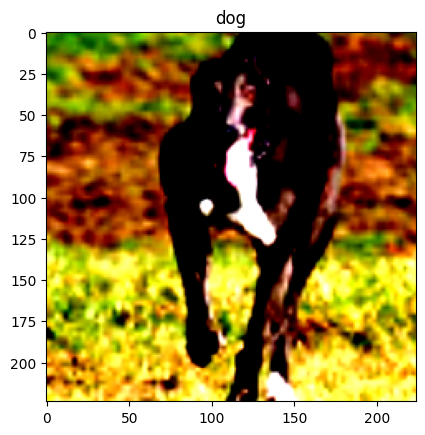

In [113]:
classes = ('plane', 'bird' ,'car', 'cat', 'deer',
           'dog', 'horse', 'mongkey', 'ship', 'truck')
def show(idx):
  nimg = train_dataset[idx][0].numpy()
  plt.title(classes[train_dataset[idx][1]])
  plt.imshow(nimg.transpose(1,2,0))

show(1)

--- [인덱스 100] 예측 결과 ---
실제 정답(Label): horse
모델 예측(Prediction): horse

--- 확률 리스트 ---
plane: 0.00%
bird: 0.00%
car: 0.00%
cat: 0.00%
deer: 0.09%
dog: 1.79%
horse: 98.09%
mongkey: 0.02%
ship: 0.00%
truck: 0.00%


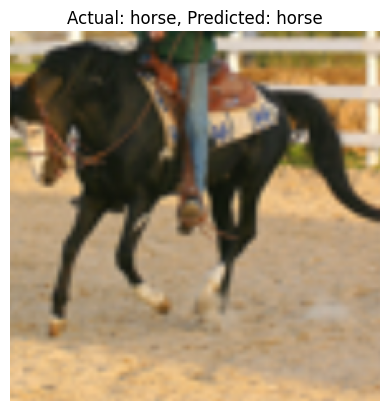

In [118]:
# 이미지 한개 예측 결과 코드
import matplotlib.pyplot as plt
import torch.nn.functional as F

image, label = test_dataset[0]

# 모델 예측을 위해 모델을 평가 모드로 전환
model.eval()

with torch.no_grad():
    # 단일 이미지에 배치 차원 추가 ([3, 224, 224] -> [1, 3, 224, 224]) 이렇게 됨
    image_input = image.unsqueeze(0).to(device)

    # 모델에 이미지 입력하여 예측
    logits = model(image_input)

    # Logits를 확률로 변환
    probs = F.softmax(logits, dim=1)

# 결과 출력
print(f"--- [인덱스 {100}] 예측 결과 ---")
print(f"실제 정답(Label): {classes[label]}")

# 가장 높은 확률을 가진 클래스의 인덱스를 찾아 예측 결과로 사용
predicted_class_idx = logits.argmax().item()
print(f"모델 예측(Prediction): {classes[predicted_class_idx]}")

print("\n--- 확률 리스트 ---")
# 텐서를 리스트로 변환하여 각 클래스별 확률을 출력
probs_list = probs[0].tolist()
for i, prob in enumerate(probs_list):
    print(f"{classes[i]}: {prob*100:.2f}%")

# 이미지 확인하기
# 모델 학습 시 이미지를 정규화(Normalize)했기 때문에,
# matplotlib으로 올바르게 시각화하려면 역정규화(Denormalize) 과정이 필요합니다.

# 학습 시 사용했던 평균(mean)과 표준편차(std) 값을 텐서로 변환
# 그리고 CPU로 이동 (img_to_plot이 CPU에 있으므로)
mean = torch.tensor([train_meanR, train_meanG, train_meanB]).cpu()
std = torch.tensor([train_stdR, train_stdG, train_stdB]).cpu()

# 1. 이미지 텐서에서 배치 차원 제거 (unsqueeze의 반대)
# 2. 이미지를 CPU로 이동 (matplotlib은 CPU 텐서나 numpy 배열을 필요로 함)
img_to_plot = image_input.squeeze(0).cpu()

# 3. 역정규화 수행: image * std + mean
img_to_plot = img_to_plot * std[:, None, None] + mean[:, None, None]

# 이미지 픽셀 값이 0에서 1 사이가 되도록 클리핑 (시각화 오류 방지)
img_to_plot = torch.clamp(img_to_plot, 0, 1)

# matplotlib.imshow는 [높이, 너비, 채널] 형태를 기대하므로, 텐서의 차원 순서를 변경
plt.imshow(img_to_plot.permute(1, 2, 0).numpy())
plt.title(f"Actual: {classes[label]}, Predicted: {classes[predicted_class_idx]}")
plt.axis('off') # 축 정보 숨기기
plt.show()